# Prérequis

Afin de pouvoir utiliser ce notebook, il est nécessaire d'avoir installé les librairies suivantes:

- numpy
- matplotlib
- aisexplorer
- folium
- urllib
- tqdm
- datetime

Pour installer ces librairies, il suffit d'exécuter la cellule suivante dans la console du notebook:

```python
!pip install numpy matplotlib aisexplorer folium urllib tqdm datetime
```

In [2]:
# IMPORT
import pandas as pd
import numpy as np
from aisexplorer.AIS import AIS
from folium.plugins import HeatMap
import folium
import urllib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
# on récupère beautifulsoup4 pour parser le html
from bs4 import BeautifulSoup
from datetime import datetime
import time
import random
import re 


# Flotte du YCC
On commence par s'intérrésser à la flotte du YCC. On va donc récupérer les données de la flotte du YCC et les afficher.

## Récupération des données 

La cellule ci-dessous récupère les données de la flotte du YCC à partir de la [feuille de calcul "flotte_ycc"](https://docs.google.com/spreadsheets/d/1Jqa28X5tSbMgV_F3SgXxd4Qv3fD4xtBE52VflBqPPBQ/edit?usp=sharing) et les stocke dans un [DataFrame de Pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html).

In [3]:
googleSheetId = "1Jqa28X5tSbMgV_F3SgXxd4Qv3fD4xtBE52VflBqPPBQ"
worksheetName = "summary"
url_fleet = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId,urllib.parse.quote(worksheetName))

TO_INT_COLUMNS = ['MMSI','Numero du skipper/armateur']


# on ouvre le fichier ggsheet et on stocke les données dans un dataframe en convertissant les colonnes de TO_INT_COLUMNS en int et en NaN si la conversion n'est pas possible
df = pd.read_csv(url_fleet)
# on convertit les colonnes de TO_INT_COLUMNS en int et en NaN si la conversion n'est pas possible
df[TO_INT_COLUMNS] = df[TO_INT_COLUMNS].astype('Int64')
df

,Nom du bateau,Numero de voile,Nom skipper/armateur,Prenom skipper/armateur,Numero du skipper/armateur,Num Licence,MMSI
0,REVES DES VOILES,NaN,FOUILLAND,CHRISTOPHE,680616629,1106867M,<NA>
1,CYRENE,FRA1968C,BRESSON,Charles-Henri,685139527,NaN,227532160
2,ELOISE II,FRA 1489,DUCHEMIN,Dominique,610514756,0889073T,<NA>
3,FAREWELL,FRA 394 C,OLLIERIC,Jerome,661566500,1273185K,<NA>
4,GREGAOU,65C,VIRONDEL,Philippe,668029114,1195710G,227443840
...,...,...,...,...,...,...,...
120,LADY BELLE,NaN,NaN,NaN,<NA>,NaN,<NA>
121,CARPE DIEM,NaN,NaN,NaN,<NA>,NaN,<NA>
122,NINITA,NaN,NaN,NaN,<NA>,NaN,235104242
123,DIVA,NaN,NaN,NaN,<NA>,NaN,<NA>


→ Nombre de bateaux dans la flotte :  122
→ Nombre de bateaux dans la flotte dont le MMMSI est connu :  50


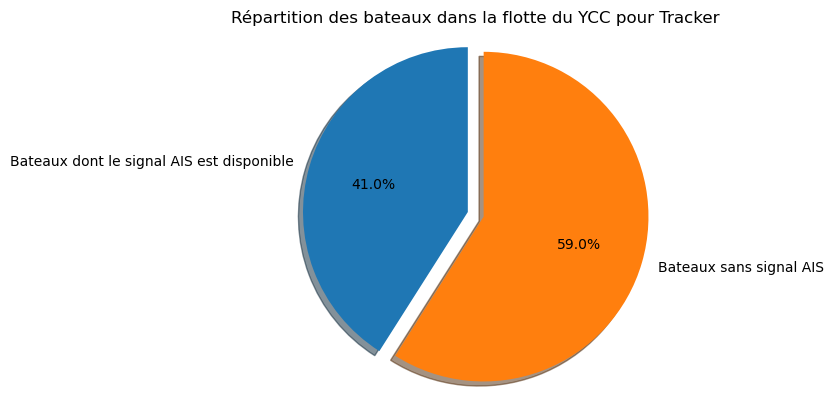

In [4]:
print("→ Nombre de bateaux dans la flotte : ", len(df['Nom du bateau'].unique()))
print("→ Nombre de bateaux dans la flotte dont le MMMSI est connu : ", len(df.MMSI.dropna().unique()))

# on plot un petit graphique pour voir la répartition de la flotte dont l'AIS à été trouvé (MMSI connu)
nb_mmsi = len(df.MMSI.dropna().unique())
nb_bateaux = len(df['Nom du bateau'].unique())
nb_bateaux_sans_mmsi = nb_bateaux - nb_mmsi
labels = 'Bateaux dont le signal AIS est disponible', 'Bateaux sans signal AIS'
sizes = [nb_mmsi, nb_bateaux_sans_mmsi]
explode = (0.1, 0)  # explode 1st slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Répartition des bateaux dans la flotte du YCC pour Tracker")
plt.show()

→ On cherche maintenant à construire un DataFrame contenant les données de la flotte du YCC afin de ensuite rechercher leurs positions 'en direct' sur une carte.

In [5]:
tracked_fleet_df = df[df['MMSI'].notnull()]
# on enlève les doublons
tracked_fleet_df = tracked_fleet_df.drop_duplicates(subset=['MMSI'],ignore_index=True)

tracked_fleet_df

,Nom du bateau,Numero de voile,Nom skipper/armateur,Prenom skipper/armateur,Numero du skipper/armateur,Num Licence,MMSI
0,CYRENE,FRA1968C,BRESSON,Charles-Henri,685139527,NaN,227532160
1,GREGAOU,65C,VIRONDEL,Philippe,668029114,1195710G,227443840
2,GRIFFON,FRA 4242 C,CHANTEREAU,Pierre-loic,686167954,1075722U,227388810
3,LA GAILLARDE,4465,PILLOT,Patrick,680445649,NaN,227189540
4,NEREE,FRA 67 C,BASOFSKI,Philippe,<NA>,0015752J,227131740
5,ROUVELON,FRA 1583 C,AUDREN,Jean-thierry,632548347,1280777T,227053330
6,THALAMUS,FR 2752C,MAZARS,Paul,607653906,1239160S,227193060
7,BLAZING STAR,A35,SIMON,Thomas,32472661107,1491610L ?,235096612
8,ILARIA,SP3281D,DEWAVRIN,Christophe,661656199,1022746L,227867680
9,DAUPHIN VERT,NaN,SIMON,Antoine,<NA>,NaN,227855670


## Récupération des données via l'API du MarineTraffic

Pour trouver la position de chaque bateau, on utilise le MMSI de ces derniers pour les rechercher sur le site [MarineTraffic](https://www.marinetraffic.com/). On utilise pour cela l'API de MarineTraffic via la librairie [aisexplorer](https://github.com/reyemb/AISExplorer).

In [6]:
# on crée un objet AIS
ais = AIS(print_query=True)

# on recherche les données AIS pour chaque bateau de la flotte7
LONG = []
LAT = []
SPEED = []
LAST_POSITION = []
COUNT_PHOTOS = []
SHIP_ID = []
CAP = []
COUNTRY_CODE = []

minTIME_SLEEP = 0
maxTIME_SLEEP = 0.5
   
# on recherche les données AIS pour chaque bateau de la flotte
for index, row in tqdm(tracked_fleet_df.iterrows(), total=tracked_fleet_df.shape[0], desc='Recherche des données AIS pour les bateaux de la flotte'):
    # on attend un temps aléatoire entre minTIME_SLEEP et maxTIME_SLEEP (float)
    time.sleep(random.uniform(minTIME_SLEEP, maxTIME_SLEEP))
    print("")
    print("→ {0} ({1})".format(row['Nom du bateau'], row['MMSI']), end='\r')
    try :
        wanted_colums = ["time_of_latest_position",
                            "flag",
                            "shipname",
                            "photo",
                            "recognized_next_port",
                            "reported_eta",
                            "reported_destination",
                            "current_port",
                            "imo",
                            "mmsi",
                            "ship_type",
                            "show_on_live_map",
                            "area",
                            "area_local",
                            "lat_of_latest_position",
                            "lon_of_latest_position",
                            "status",
                            "eni",
                            "speed",
                            "course",
                            "draught",
                            "navigational_status",
                            "year_of_build",
                            "length",
                            "width",
                            "dwt",
                            "current_port_unlocode",
                            "current_port_country",
                            ]
        substring = ""
        substring = substring.join([wanted_colums[i] + "," for i in range(len(wanted_colums))]) 
        str = "https://www.marinetraffic.com/en/data/?asset_type=vessels&columns={1}&mmsi|eq|mmsi={0}".format(row['MMSI'], substring)
        reply = ais.get_data_by_url(str)
        if type(reply) == list :
            response = reply[0]
            LONG.append(response['LON'])
            LAT.append(response['LAT'])
            SPEED.append(response['SPEED'])
            LAST_POSITION.append(response['LAST_POS'])
            COUNT_PHOTOS.append(response['COUNT_PHOTOS'])      
            SHIP_ID.append(response['SHIP_ID'])
            CAP.append(response['COURSE'])
            COUNTRY_CODE.append(response['CODE2'])

            print("→ {0} ({1}) : 'FOUND'".format(row['Nom du bateau'], row['MMSI']))
            print('Position :',response['LON'], response['LAT'])
            print('REPONSE : ', response)
        else : 
            print(type(reply))
            tracked_fleet_df = tracked_fleet_df.drop(index=index)
            print("→ {0} ({1}) : 'UNFOUND → {2}'".format(row['Nom du bateau'], row['MMSI'], reply))
    except Exception as e :
        # on print l'erreur et son explication
        print("→ {0} ({1}) : 'UNFOUND → {2}'".format(row['Nom du bateau'], row['MMSI'], e))
        tracked_fleet_df = tracked_fleet_df.drop(index=index)

tracked_fleet_df['LONG'] = LONG
tracked_fleet_df['LAT'] = LAT
tracked_fleet_df['SPEED'] = SPEED
tracked_fleet_df['LAST_POSITION'] = LAST_POSITION
tracked_fleet_df['COUNT_PHOTOS'] = COUNT_PHOTOS
tracked_fleet_df['SHIP_ID'] = SHIP_ID
tracked_fleet_df['CAP'] = CAP
tracked_fleet_df['COUNTRY_CODE'] = COUNTRY_CODE

tracked_fleet_df['LONG'] = tracked_fleet_df['LONG'].astype('float64')
tracked_fleet_df['LAT'] = tracked_fleet_df['LAT'].astype('float64')
tracked_fleet_df['SPEED'] = tracked_fleet_df['SPEED'].astype('float64')
tracked_fleet_df['SHIP_ID'] = tracked_fleet_df['SHIP_ID'].astype('int64')
tracked_fleet_df['CAP'] = tracked_fleet_df['CAP'].astype('float64')
tracked_fleet_df['COUNTRY_CODE'] = tracked_fleet_df['COUNTRY_CODE'].astype('str')
try :
    tracked_fleet_df['COUNT_PHOTOS'] = tracked_fleet_df['COUNT_PHOTOS'].astype('int64')
except :
    print("→ Erreur lors de la conversion de la colonne COUNT_PHOTOS en int64")
    pass

tracked_fleet_df

Recherche des données AIS pour les bateaux de la flotte:   0%|          | 0/50 [00:00<?, ?it/s]


→ CYRENE (227532160) : 'FOUND'
Position : -3.025185 47.58607
REPONSE :  {'SHIP_ID': '177264', 'IMO': '0', 'MMSI': '227532160', 'CALLSIGN': 'FW5706', 'SHIPNAME': 'CYRENE', 'TYPE_COLOR': '9', 'LAST_POS': 1685469202, 'TIMEZONE': '1', 'CODE2': 'FR', 'COUNTRY': 'France', 'COUNT_PHOTOS': '0', 'NEXT_PORT_NAME': None, 'NEXT_PORT_COUNTRY': None, 'NEXT_PORT_ID': None, 'ETA': None, 'DESTINATION': 'No data (CLASS B transponder)', 'CURRENT_PORT_COUNTRY': None, 'TYPE_SUMMARY': 'Sailing Vessel', 'COURSE': '271', 'LON': '-3.025185', 'LAT': '47.58607', 'INLAND_ENI': None, 'STATUS_NAME': 'Class B', 'YOB': None, 'DWT': None, 'CURRENT_PORT_UNLOCODE': None, 'AREA_CODE': 'UKC - UK Coast & Atlantic', 'ETA_OFFSET': None, 'SPEED': '0.0', 'DRAUGHT': '0.0', 'LENGTH': '14.0', 'WIDTH': '4.0', 'STATUS': 'ACTIVE', 'ETA_UPDATED': None, 'DISTANCE_TO_GO': '0', 'AREA_NAME': 'Biscay Bay', 'PORT_ID': None, 'CURRENT_PORT': None, 'CTA_ROUTE_FORECAST': 'false'}

→ GREGAOU (227443840) : 'FOUND'
Position : -4.847515 48.03897


,Nom du bateau,Numero de voile,Nom skipper/armateur,Prenom skipper/armateur,Numero du skipper/armateur,Num Licence,MMSI,LONG,LAT,SPEED,LAST_POSITION,COUNT_PHOTOS,SHIP_ID,CAP,COUNTRY_CODE
0,CYRENE,FRA1968C,BRESSON,Charles-Henri,685139527,NaN,227532160,-3.025185,47.58607,0.0,1685469202,0,177264,271.0,FR
1,GREGAOU,65C,VIRONDEL,Philippe,668029114,1195710G,227443840,-4.847515,48.03897,0.2,1688378675,2,5546487,183.0,FR
2,GRIFFON,FRA 4242 C,CHANTEREAU,Pierre-loic,686167954,1075722U,227388810,-2.502828,43.38092,4.8,1688485062,1,3578416,171.0,FR
3,LA GAILLARDE,4465,PILLOT,Patrick,680445649,NaN,227189540,-1.151318,46.15203,0.0,1687054879,0,5547668,NaN,FR
4,NEREE,FRA 67 C,BASOFSKI,Philippe,<NA>,0015752J,227131740,6.373722,43.12867,6.4,1685775982,0,174257,172.0,FR
5,ROUVELON,FRA 1583 C,AUDREN,Jean-thierry,632548347,1280777T,227053330,-3.995212,47.72483,0.3,1688464305,2,173194,225.0,FR
6,THALAMUS,FR 2752C,MAZARS,Paul,607653906,1239160S,227193060,-4.118337,47.88076,1.6,1687691512,5,175092,38.0,FR
7,BLAZING STAR,A35,SIMON,Thomas,32472661107,1491610L ?,235096612,-3.354243,47.71104,0.4,1688217753,2,200009,23.0,GB
8,ILARIA,SP3281D,DEWAVRIN,Christophe,661656199,1022746L,227867680,-4.339530,48.09981,0.0,1686495945,6,5620566,NaN,FR
9,DAUPHIN VERT,NaN,SIMON,Antoine,<NA>,NaN,227855670,-1.151927,46.15428,1.3,1688398297,1,5562261,53.0,FR


## Informations supplémentaires

Une fois les données récupérées, on peut, entre autres, afficher les informations suivantes:

- Nom du bateau
- Position du bateau
- Vitesse du bateau
- Heure de la dernière mise à jour des données

Néanmoins, pour avoir quelques info supplémentaires, on peut chercher sur le site du [Musée Maritime de La Rochelle](https://www.museemaritimelarochelle.fr/) en utilisant le nom du bateau.

In [7]:
# Pour chaque bateau, on check si il y a une page sur le site du musée maritime de La Rochelle
PAGE_LINK = []
TIME_SLEEP = 0.5

minTIME_SLEEP = 0
maxTIME_SLEEP = 0.2

for index, row in tqdm(tracked_fleet_df.iterrows(), total=tracked_fleet_df.shape[0], desc="Recherche des pages sur 'https://museemaritime.larochelle.fr'"):
    # on attend un temps aléatoire entre minTIME_SLEEP et maxTIME_SLEEP (float)
    time.sleep(random.uniform(minTIME_SLEEP, maxTIME_SLEEP))
    print("")
    print("→ {0} ({1})".format(row['Nom du bateau'], row['MMSI']), end='\r')
    try :
        # on met en minuscule et on remplace les espaces par des tirets
        nom = row['Nom du bateau'].lower().replace(" ", "-")
        str = "https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/{0}".format(nom)
        response = requests.get(str)
        if response.status_code == 200 :
            print("→ {0} ({1}) : 'FOUND'\n{2}".format(row['Nom du bateau'], row['MMSI'], response.url))
            PAGE_LINK.append(response.url)
        else :
            print("→ {0} ({1}) : 'UNFOUND'".format(row['Nom du bateau'], row['MMSI']))
            PAGE_LINK.append(np.nan)
        
         
    except Exception as e :
        print("→ {0} ({1}) : 'ERREUR → {2}'".format(row['Nom du bateau'], row['MMSI'], e))
        PAGE_LINK.append(np.nan)

tracked_fleet_df['PAGE_LINK'] = PAGE_LINK
tracked_fleet_df

Recherche des pages sur 'https://museemaritime.larochelle.fr':   0%|          | 0/49 [00:00<?, ?it/s]


→ CYRENE (227532160) : 'UNFOUND'

→ GREGAOU (227443840) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/gregaou

→ GRIFFON (227388810) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/griffon

→ LA GAILLARDE (227189540) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/la-gaillarde

→ NEREE (227131740) : 'UNFOUND'

→ ROUVELON (227053330) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/rouvelon

→ THALAMUS (227193060) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/thalamus

→ BLAZING STAR (235096612) : 'UNFOUND'

→ ILARIA (227867680) : 'UNFOUND'

→ DAUPHIN VERT (227855670) : 'FOUND'
https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/dauphin-

,Nom du bateau,Numero de voile,Nom skipper/armateur,Prenom skipper/armateur,Numero du skipper/armateur,Num Licence,MMSI,LONG,LAT,SPEED,LAST_POSITION,COUNT_PHOTOS,SHIP_ID,CAP,COUNTRY_CODE,PAGE_LINK
0,CYRENE,FRA1968C,BRESSON,Charles-Henri,685139527,NaN,227532160,-3.025185,47.58607,0.0,1685469202,0,177264,271.0,FR,NaN
1,GREGAOU,65C,VIRONDEL,Philippe,668029114,1195710G,227443840,-4.847515,48.03897,0.2,1688378675,2,5546487,183.0,FR,https://museemaritime.larochelle.fr/au-dela-de...
2,GRIFFON,FRA 4242 C,CHANTEREAU,Pierre-loic,686167954,1075722U,227388810,-2.502828,43.38092,4.8,1688485062,1,3578416,171.0,FR,https://museemaritime.larochelle.fr/au-dela-de...
3,LA GAILLARDE,4465,PILLOT,Patrick,680445649,NaN,227189540,-1.151318,46.15203,0.0,1687054879,0,5547668,NaN,FR,https://museemaritime.larochelle.fr/au-dela-de...
4,NEREE,FRA 67 C,BASOFSKI,Philippe,<NA>,0015752J,227131740,6.373722,43.12867,6.4,1685775982,0,174257,172.0,FR,NaN
5,ROUVELON,FRA 1583 C,AUDREN,Jean-thierry,632548347,1280777T,227053330,-3.995212,47.72483,0.3,1688464305,2,173194,225.0,FR,https://museemaritime.larochelle.fr/au-dela-de...
6,THALAMUS,FR 2752C,MAZARS,Paul,607653906,1239160S,227193060,-4.118337,47.88076,1.6,1687691512,5,175092,38.0,FR,https://museemaritime.larochelle.fr/au-dela-de...
7,BLAZING STAR,A35,SIMON,Thomas,32472661107,1491610L ?,235096612,-3.354243,47.71104,0.4,1688217753,2,200009,23.0,GB,NaN
8,ILARIA,SP3281D,DEWAVRIN,Christophe,661656199,1022746L,227867680,-4.339530,48.09981,0.0,1686495945,6,5620566,NaN,FR,NaN
9,DAUPHIN VERT,NaN,SIMON,Antoine,<NA>,NaN,227855670,-1.151927,46.15428,1.3,1688398297,1,5562261,53.0,FR,https://museemaritime.larochelle.fr/au-dela-de...


### Récupération d'une petite image du bateau

En partant du principe, que chaque page du musée maritime contient une image du bateau concerné, on peut ainsi récupérer cette image et l'afficher dans le notebook par des technique de scrapping.
On commence par définir une image par défaut (enfin son url)...

C:\Users\pcau2\AppData\Local\Temp\ipykernel_26424\3819092710.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  plt.imshow(mpimg.imread(DEFAULT_IMAGE_URL))


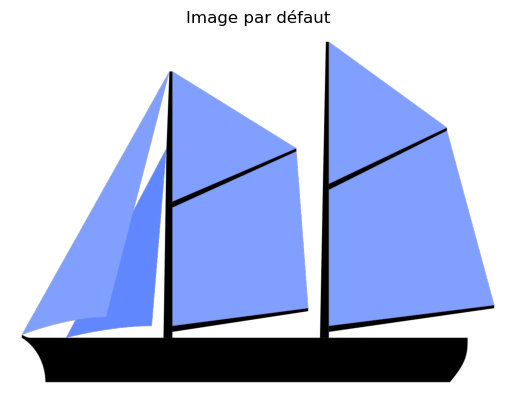

In [12]:
DEFAULT_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Sail_plan_schooner.svg/1200px-Sail_plan_schooner.svg.png"
# on affiche l'image par défaut pour vérifier que c'est bien la bonne
plt.imshow(mpimg.imread(DEFAULT_IMAGE_URL))
# on retire les axes
plt.axis('off')
plt.title("Image par défaut")
# on affiche l'image
plt.show()

On définit maintenant une fonction qui va chercher l'image du bateau sur le site du musée maritime. La technique ici est d'inspecter le code source de la page du bateau et de récupérer l'url de l'image en repérant la balise des patterns. Ici, on peut souligner le fait que toutes les images des bateaux sont stockées dans le même dossier, ce qui facilite la récupération de l'image, certes, mais ce n'est pas si simple... En effet, sûrement pour protéger les droits d'auteurs les noms des images sont un peu "cryptés" (ex: `gregaou.jpg` devient `csm_Gregaou_2de757a26b.jpg`). La technique la plus efficace consiste donc à scrapper l'élément, à repérer la balise `figure` de classe `image` (propre à l'image de présentation), d'en extraire la sous-balise `img` et de récupérer l'attribut `src` de cette dernière.

In [13]:
# on crée une fonction qui va récupérer l'image d'un bateau
def get_image_from_page_link(url, ship_id):
    """
    Fonction qui récupère l'image d'un bateau à partir de son lien sur le site du musée maritime de La Rochelle par scrapping
    """
    if pd.isna(url) :
        try :
            response = requests.get(f'https://photos.marinetraffic.com/ais/showphoto.aspx?shipid={ship_id}&size=thumb600')
            if response.status_code == 200 :
                print(" → Scrapping de l'"+'image du bateau sur "https://photos.marinetraffic.com/"')
                print("  ... Image du bateau : {0}\n".format(response.url))
                return response.url
            else :
                raise Exception(f'Marine Traffic : {response.status_code}')
        
        except Exception as e :
            print("  → Pas d'url pour le bateau donc on retourne l'image par défaut\n")
            return DEFAULT_IMAGE_URL
    try :
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        print("  → Scrapping de l'image du bateau sur '{0}'\n".format(url))
        image_url = soup.find("figure", {"class": "image"}).find("img")['src']
        print("  ... Image du bateau : {0}\n".format(image_url))
        return image_url
    except Exception as e :
        print("  → Erreur lors de la récupération de l'image du bateau → {0}".format(e))
        return DEFAULT_IMAGE_URL

In [10]:
IMAGES_URL = []
for index, row in tqdm(tracked_fleet_df.iterrows(), total=tracked_fleet_df.shape[0], desc="Récupération des images des bateaux"):
    print("")
    print("► {0} ({1})".format(row['Nom du bateau'], row['MMSI']))
    try :
        IMAGES_URL.append(get_image_from_page_link(row['PAGE_LINK'],row['SHIP_ID']))
    except Exception as e :
        print("→ Erreur lors de la récupération de l'image du bateau → {0}".format(e))
        IMAGES_URL.append(DEFAULT_IMAGE_URL)

tracked_fleet_df['IMAGE_URL'] = IMAGES_URL
tracked_fleet_df

Récupération des images des bateaux:   0%|          | 0/49 [00:00<?, ?it/s]


► CYRENE (227532160)
  → Pas d'url pour le bateau donc on retourne l'image par défaut


► GREGAOU (227443840)
  → Scrapping de l'image du bateau sur 'https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/gregaou'

  ... Image du bateau : https://museemaritime.larochelle.fr/fileadmin/_processed_/1/3/csm_Gregaou_2de757a26b.jpg


► GRIFFON (227388810)
  → Scrapping de l'image du bateau sur 'https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/griffon'

  ... Image du bateau : https://museemaritime.larochelle.fr/fileadmin/_processed_/a/3/csm_Griffon-2015-_c_Jakez-2_e99ebff87b.jpg


► LA GAILLARDE (227189540)
  → Scrapping de l'image du bateau sur 'https://museemaritime.larochelle.fr/au-dela-de-la-visite/a-decouvrir-a-proximite/yatchs-classiques/la-gaillarde'

  ... Image du bateau : https://museemaritime.larochelle.fr/fileadmin/_processed_/3/9/csm_La_Gaillarde_c_JoubertChasseMaree_eb2a811296.jpg


►

,Nom du bateau,Numero de voile,Nom skipper/armateur,Prenom skipper/armateur,Numero du skipper/armateur,Num Licence,MMSI,LONG,LAT,SPEED,LAST_POSITION,COUNT_PHOTOS,SHIP_ID,CAP,COUNTRY_CODE,PAGE_LINK,IMAGE_URL
0,CYRENE,FRA1968C,BRESSON,Charles-Henri,685139527,NaN,227532160,-3.025185,47.58607,0.0,1685469202,0,177264,271.0,FR,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,GREGAOU,65C,VIRONDEL,Philippe,668029114,1195710G,227443840,-4.847515,48.03897,0.2,1688378675,2,5546487,183.0,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...
2,GRIFFON,FRA 4242 C,CHANTEREAU,Pierre-loic,686167954,1075722U,227388810,-2.502828,43.38092,4.8,1688485062,1,3578416,171.0,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...
3,LA GAILLARDE,4465,PILLOT,Patrick,680445649,NaN,227189540,-1.151318,46.15203,0.0,1687054879,0,5547668,NaN,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...
4,NEREE,FRA 67 C,BASOFSKI,Philippe,<NA>,0015752J,227131740,6.373722,43.12867,6.4,1685775982,0,174257,172.0,FR,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,ROUVELON,FRA 1583 C,AUDREN,Jean-thierry,632548347,1280777T,227053330,-3.995212,47.72483,0.3,1688464305,2,173194,225.0,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...
6,THALAMUS,FR 2752C,MAZARS,Paul,607653906,1239160S,227193060,-4.118337,47.88076,1.6,1687691512,5,175092,38.0,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...
7,BLAZING STAR,A35,SIMON,Thomas,32472661107,1491610L ?,235096612,-3.354243,47.71104,0.4,1688217753,2,200009,23.0,GB,NaN,https://photos.marinetraffic.com/ais/showphoto...
8,ILARIA,SP3281D,DEWAVRIN,Christophe,661656199,1022746L,227867680,-4.339530,48.09981,0.0,1686495945,6,5620566,NaN,FR,NaN,https://photos.marinetraffic.com/ais/showphoto...
9,DAUPHIN VERT,NaN,SIMON,Antoine,<NA>,NaN,227855670,-1.151927,46.15428,1.3,1688398297,1,5562261,53.0,FR,https://museemaritime.larochelle.fr/au-dela-de...,https://museemaritime.larochelle.fr/fileadmin/...


In [35]:
# on génère une carte html

# on commence par ranger les bateaux par ordre alphabétique
tracked_fleet_df = tracked_fleet_df.sort_values(by=['Nom du bateau'])
tracked_fleet_df = tracked_fleet_df.reset_index(drop=True) # on reset l'index

ZOOM = 6 # zoom de la carte par défaut
MAX_ZOOM = 25 # zoom max
MIN_ZOOM = 3 # zoom min
ZOOM_LEVEL = 15 # zoom level pour focus sur un bateau

# Pop up des bateaux
POP_UPS = {} # dictionnaire qui va contenir les popups des bateaux en fonction de leur MMSI
WIDTH = 320 # largeur de la popup
HEIGHT = 400 # hauteur de la popup
POSITION_BOAT_SCHEME = 90 # position du bateau sur le schéma
TIME_TO_TURN = 2 # temps pour tourner le bateau afin de générer l'animation (en secondes)

# focus sur un bateau
icon_size = (25, 25) # taille des icones
icon_targeted_size = (35, 35) # taille des icones quand on clique dessus
offset = (0, 0.001) # offset des icones (longitude, latitude)

m = folium.Map(location=[46.227638, 2.213749], zoom_start=ZOOM,max_zoom=25, min_zoom=3,control_scale=True,name ='Fotte_YCC')
# on change le label du fond de carte
folium.TileLayer('cartodbpositron',name="Positron").add_to(m, name='Positron')
folium.TileLayer('cartodbdark_matter',name="Dark Matter").add_to(m, name='Dark Matter')

# on génère les marqueurs et popups pour chaque bateau
for index, row in tracked_fleet_df.iterrows(): 
    ANGLE_TO_TURN = row['CAP'] - POSITION_BOAT_SCHEME # angle à tourner pour que le bateau soit dans le bon sens sur le schéma
    last_position = datetime.fromtimestamp(row['LAST_POSITION'])
    if pd.isna(row['CAP']) :
        row['CAP'] = 0 # on met 0 si on a pas de cap par défaut pour l'affichage

    if row['PAGE_LINK'] is np.nan :
        # on ajoute un marker sur la carte
        HTML = f"""
        <div style="width: {WIDTH}px;
            height: {HEIGHT}px;
            overflow-y: auto;
            overflow-x: hidden;
            padding: 5px;
            ">
        <h3><b>{row['Nom du bateau']}</b> ({row['COUNTRY_CODE']})</h3>
        <br>
        <!-- on ajoute une image du bateau si on peut -->
        <img src="{row['IMAGE_URL']}" alt="{row['Nom du bateau']}" 
            style="width:100%;
            max-width: 300px; 
            height: auto;
            border-radius: 5px;
            border: 1px solid #ddd;
            padding: 5px;
            margin-bottom: 10px;
            /* GREY */
            display: block;
            margin-left: auto;
            margin-right: auto;
                "/>

        <p style="font-size: 14px;">
            <!-- on crée une box qui aura à gauche le cap et à droite le schéma du bateau -->
            <div style="width: 100%;
                border: 1px solid #ddd;
                border-radius: 5px;
                padding: 5px;
                margin-bottom: 10px;
                /* GREY */
                background-color: #f2f2f2;
                ">
            <div style="float: left;
                position: relative;
                max-width: {int(WIDTH/1.5)}px;
                height: 15px;
                display: block;
                margin-left: auto;
                margin-right: auto;
                padding: 5px;
                ">
            <b>Vitesse : </b> {row['SPEED']} noeuds<br>
            <b>Cap : </b> {row['CAP']}°<br>
            <b>Latitude : </b> {row['LAT']}°<br>
            <b>Longitude : </b> {row['LONG']}°<br>
            <b>Dernière position : </b> {last_position}<br>
            </div>
            <!-- on affiche le schéma du bateau au centre de la div, tournée de ANGLE_TO_TURN pour faire le cap -->
            <img class='tourne' src="images/boat.png" alt="boat" 
                style="width: 100%; 
                position: relative;
                max-width: {int(WIDTH/3.5)}px; 
                height: auto; 
                transform: rotate({ANGLE_TO_TURN}deg); 
                display: block; 
                margin-left: auto; 
                margin-right: 5%;
                "/>
            </div>
        </p>

        <button 
            onclick="window.open('https://www.marinetraffic.com/en/ais/details/ships/mmsi:{row['MMSI']}')"
            style="background-color: #4CAF50; /* Green */
            border: none;
            color: white;
            padding: 15px 32px;
            text-align: center;
            text-decoration: none;
            /* on centre le bouton */
            display: block;
            margin-left: auto;
            margin-right: auto;
            font-size: 16px;
            cursor: pointer;
            border-radius: 12px;
            box-shadow: 0 0 2px 1px rgba(0, 0, 0, 0.2);
        ">
            Voir sur Marine Traffic</button>
        </div> 
        """
        HTML +="""
            <style>
            @-moz-keyframes spin {
            100% { -moz-transform: rotate(-360deg); }
            }
            @-webkit-keyframes spin {
            100% { -webkit-transform: rotate(-360deg); }
            }
            @keyframes spin {
            100% { -webkit-transform: rotate(-360deg); transform: rotate(-360deg); }
            }
        """
        HTML += f"""
        .tourne {{
        -webkit-animation-name: spin;
        -webkit-animation-duration: {TIME_TO_TURN}s;
        -webkit-animation-iteration-count: 1;
        -webkit-animation-timing-function: ease-out;
        -moz-animation-name: spin;
        -moz-animation-duration: {TIME_TO_TURN}s;
        -moz-animation-iteration-count: 1;
        -moz-animation-timing-function: ease-out;
        animation-name: spin;
        animation-duration: {TIME_TO_TURN}s;
        animation-iteration-count: 1;
        animation-timing-function: ease-out;
        }}
        </style>
        """
    
    else : # on ajoute un petit bouton en bas sous forme de livre qui permet d'afficher les informations du bateau en redirigeant vers la page du musée maritime de La Rochelle
        HTML = f"""
        <div style="width: {WIDTH}px;
            height: {HEIGHT}px;
            overflow-y: auto;
            overflow-x: hidden;
            padding: 5px;
            ">
        <h3><b>{row['Nom du bateau']}</b> ({row['COUNTRY_CODE']})</h3>
        <br>
        <img src="{row['IMAGE_URL']}" alt="{row['Nom du bateau']}" 
            style="width:100%;
            max-width: 300px; 
            height: auto;
            border-radius: 5px;
            border: 1px solid #ddd;
            padding: 5px;
            margin-bottom: 10px;
            display: block;
            margin-left: auto;
            margin-right: auto;
            "/>

        <p style="font-size: 14px;">
            <!-- on crée une box qui aura à gauche le cap et à droite le schéma du bateau -->
            <div style="width: 100%;
                border: 1px solid #ddd;
                border-radius: 5px;
                padding: 5px;
                margin-bottom: 10px;
                /* GREY */
                background-color: #f2f2f2;
                ">
            <div style="float: left;
                position: relative;
                max-width: {int(WIDTH/1.5)}px;
                height: 15px;
                display: block;
                margin-left: auto;
                margin-right: auto;
                padding: 5px;
                ">
            <b>Vitesse : </b> {row['SPEED']} noeuds<br>
            <b>Cap : </b> {row['CAP']}°<br>
            <b>Latitude : </b> {row['LAT']}°<br>
            <b>Longitude : </b> {row['LONG']}°<br>
            <b>Dernière position : </b> {last_position}<br>
            </div>
            <!-- on affiche le schéma du bateau au centre de la div, tournée de ANGLE_TO_TURN pour faire le cap -->
            <img class='tourne' src="images/boat.png" alt="boat" 
                style="width: 100%; 
                position: relative;
                max-width: {int(WIDTH/3.5)}px; 
                height: auto; 
                transform: rotate({ANGLE_TO_TURN}deg); 
                display: block; 
                margin-left: auto; 
                margin-right: 5%;
                "/>
            </div>
        </p>

        <a href="{row['PAGE_LINK']}" target="_blank" title='En apprendre plus sur le site du musée maritime de La Rochelle'>
            <img src="images/idea.png" alt="Livre"
            style="
            width: 50px;
            height: auto;
            border-radius: 50%;
            border: 1px solid #ddd;
            padding: 5px;
            margin-bottom: 10px;
            box-shadow: 0 0 2px 1px rgba(0, 0, 0, 0.2);
            display: block;
            margin-left: auto;
            margin-right: auto;">
        </a>

 
        <button 
            onclick="window.open('https://www.marinetraffic.com/en/ais/details/ships/mmsi:{row['MMSI']}')"
            style="background-color: #4CAF50; /* Green */
            border: none;
            color: white;
            padding: 15px 32px;
            text-align: center;
            text-decoration: none;
            /* on centre le bouton */
            display: block;
            margin-left: auto;
            margin-right: auto;
            font-size: 16px;
            cursor: pointer;
            border-radius: 12px;
            box-shadow: 0 0 2px 1px rgba(0, 0, 0, 0.2);
        ">
            Voir sur Marine Traffic</button>
        </div>
        """    
        HTML +="""
            <style>
            @-moz-keyframes spin {
            100% { -moz-transform: rotate(-360deg); }
            }
            @-webkit-keyframes spin {
            100% { -webkit-transform: rotate(-360deg); }
            }
            @keyframes spin {
            100% { -webkit-transform: rotate(-360deg); transform: rotate(-360deg); }
            }
        """
        HTML += f"""
        .tourne {{
        -webkit-animation-name: spin;
        -webkit-animation-duration: {TIME_TO_TURN}s;
        -webkit-animation-iteration-count: 1;
        -webkit-animation-timing-function: ease-out;
        -moz-animation-name: spin;
        -moz-animation-duration: {TIME_TO_TURN}s;
        -moz-animation-iteration-count: 1;
        -moz-animation-timing-function: ease-out;
        animation-name: spin;
        animation-duration: {TIME_TO_TURN}s;
        animation-iteration-count: 1;
        animation-timing-function: ease-out;
        }}
        </style>
        """

    MAX_WIDTH = 300
    MAX_HEIGHT = 400
    popup = folium.Popup(lazy=True, html=HTML, width=WIDTH, max_height=MAX_HEIGHT)
    POP_UPS[row['MMSI']] = popup.get_name()

    marker = folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=popup,
        icon=folium.features.CustomIcon('Tracker_fleet_YCC/images/ship.png', 
                                        icon_size=icon_size, 
                                        popup_anchor=(0, -20), 
                                        icon_anchor=(0, 0),
                                        shadow_image=None,
                                        ),
        id='marker-{}'.format(row['MMSI']),
        )
    marker.add_to(m)
    
# on affiche la carte
folium.LayerControl().add_to(m, name='Layer Control')

# on ajoute une petite box par dessus la carte pour afficher les informations de la carte
# on crée une box qui contiendra la liste des bateaux, la date de la dernière mise à jour et la possibilité focus sur un bateau
today = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
dictionnary_country = {'FR':'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Flag_of_France_%281794%E2%80%931815%2C_1830%E2%80%931974%2C_2020%E2%80%93present%29.svg/1280px-Flag_of_France_%281794%E2%80%931815%2C_1830%E2%80%931974%2C_2020%E2%80%93present%29.svg.png',
                       'GB':'https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Flag_of_the_United_Kingdom_%283-5%29.svg/1920px-Flag_of_the_United_Kingdom_%283-5%29.svg.png',
                       'IT':'https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Flag_of_Italy.svg/1280px-Flag_of_Italy.svg.png',
                       'MT':'https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Flag_of_Malta.svg/120px-Flag_of_Malta.svg.png',
                       'NL':'https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Flag_of_the_Netherlands.svg/120px-Flag_of_the_Netherlands.svg.png',
                       'PT':'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Flag_of_Portugal.svg/120px-Flag_of_Portugal.svg.png',
                       'ES':'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Flag_of_Spain.svg/120px-Flag_of_Spain.svg.png',
                       'US':'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e2/Flag_of_the_United_States_%28Pantone%29.svg/152px-Flag_of_the_United_States_%28Pantone%29.svg.png',
                       'CH':'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Flag_of_Switzerland.svg/80px-Flag_of_Switzerland.svg.png',
                       'BE':'https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Flag_of_Belgium.svg/92px-Flag_of_Belgium.svg.png',
                       'DE':'https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Flag_of_Germany.svg/134px-Flag_of_Germany.svg.png',
                       'DK':'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Flag_of_Denmark.svg/106px-Flag_of_Denmark.svg.png',
                       'IE':'https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Flag_of_Ireland.svg/160px-Flag_of_Ireland.svg.png',
                       'NO':'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Flag_of_Norway.svg/110px-Flag_of_Norway.svg.png',
                       'SE':'Sweden',}
for i in tracked_fleet_df['COUNTRY_CODE'].unique(): # on parcourt tous les pays pour vérifier qu'ils sont bien dans la liste des pays supportés
    if i not in dictionnary_country:
        print(f"-- Le code pays {i} n'est pas dans la liste des pays, merci de l'ajouter --")

HTML = """
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title> Flotte YCC</title>
<link rel="icon" type="image/png" href="images/logo.png" />
</head>
<!-- on crée un box qui peut être déplacée si on clic dessus et on maintient le clic -->
<div id="box" style="width: 15%;
    position: absolute;
    /* on le met au dessus de la carte */
    z-index: 999;
    /* on le met en haut à droite */
    top: 20%;
    left: 20px;
    /* on lui donne une bordure gris foncé */
    border: 1px solid #ddd;
    border-radius: 10px;
    /* on lui donne une ombre grise comme une popup */
    box-shadow: 0 0 2px 1px #ddd;
    background-color: white;
    padding: 5px;
    ">
    <img onclick="window.open('https://www.yachtclubclassique.com/')"
        class=zoomable1 src="images/logo.png" alt="logo"
        style="width: 50%; 
            height: auto; 
            display: block; 
            margin-left: auto; 
            margin-right: auto; 
            margin-top:5px;
            border-radius: 50%;"/>
    <img src="images/yacht-club-classique.png" alt="YCC" style="width: 95%; height: auto; display: block; margin-left: auto; margin-right: auto; margin-top:5px; margin-bottom:10px">
    <div id="track_container" style="overflow-y: scroll; height: 200px;"
     padding: 5px;"/>
"""

for index, row in tracked_fleet_df.iterrows(): # on parcourt tous les bateaux
    assert ZOOM_LEVEL > MIN_ZOOM and ZOOM_LEVEL < MAX_ZOOM, f"Le niveau de zoom doit être compris entre 0 et {MAX_ZOOM-1}"
    HTML += f"""
    <!-- on ajoute le nom du bateau à la liste. Quand on click dessus on déclenche la fonction setView() définie plus bas -->
        <a class=zoomable2 onclick="printTrack('{row['Nom du bateau']}','{index}'); setView({row['LAT']}, {row['LONG']}, {ZOOM_LEVEL},{index});"   
        style="
        color: #000;
        text-decoration: none;
        display: block;
        height: 45px;
        padding: 5px;
        border-radius: 5px;
        border: 1px solid #ddd;
        margin-bottom: 5px;
        text-align: left;
        /* on rajoute une ombre grise */
        box-shadow: 0 0 2px 1px #ddd;
        ">
            <!-- on met le nom du bateau à gauche et le drapeau à droite -->
            <p style="float: left;
                margin-top: 8px;
                margin-left: 5px;
                  margin-right: auto;
                font-size: 15px;
                font-family: Georgia, serif;">{row['Nom du bateau']}</p>
            <img src="{dictionnary_country[row['COUNTRY_CODE']]}" alt="drapeau" 
            style="  width: auto;
                    height: 25px;
                    display: block;
                    margin-left: auto;
                    margin-right: 15px;
                    float: right;
                    border-radius: 20%;
                    margin-top: 5px;
                    margin-bottom: auto;
                    ">
        """
    if not(pd.isna(row['PAGE_LINK'])): # si le bateau a une page web on ajoute un lien vers cette page : 
            HTML += f"""
            <img id="is_mmr_{index}" class=is_mrr src="images/logo_mmr.png" alt="logo_mmr"
                style="width: auto;
                    height: 35px;
                    display: block;
                    margin-left: auto;
                    margin-right: 15px;
                    float: right;
                    border-radius: 20%;
                    box-shadow: 0 0 2px 1px #e6e6e6;
                    margin-top: 0px;"/>
                """
    HTML += f"""
        </a>
    
        <script>
        function printTrack(NAME, index) {{
            console.log('... Tracking sur ' + NAME +' ('+ index+ ') ...');
        }}

        function setView(lat, long, zoom,index) {{
            console.log('setView(' + lat + ', ' + long + ', ' + zoom + ')');
            // on descend un peu les coordonnées cible pour que la popup soit bien centrée sur la carte 
            lat = lat + {offset[1]} ;
            long = long + {offset[0]} ;
            {m.get_name()}.setView([lat, long], zoom);
            // On cherche tous les éléments avec la classe leaflet-marker-icon leaflet-zoom-animated leaflet-interactive
            // On les met dans une liste
            var list_markers = document.getElementsByClassName('leaflet-marker-icon leaflet-zoom-animated leaflet-interactive');
            // on récupère le marker qui a le même index que le bateau 
            var marker = list_markers[index];

            // si trageted_marker est défini, on le met à jour 
            if (typeof targeted_marker !== 'undefined') {{
            
                // on change la source de l'image de targeted_marker pour qu'il reprenne l'image ship.png 
                targeted_marker.src = 'images/ship.png';
                // on change la taille de l'image 
                targeted_marker.style.width = '{icon_size[0]}'+'px';
                targeted_marker.style.height = '{icon_size[1]}'+'px';
                // on redefini le targeted_marker 
                targeted_marker = marker;
                // on défini la source de l'image de targeted_marker pour qu'il prenne l'image logo.png
                targeted_marker.src = 'images/logo.png';
                // on change la taille de l'image
                targeted_marker.style.width = '{icon_targeted_size[0]}'+'px';
                targeted_marker.style.height = '{icon_targeted_size[1]}'+'px'; 

            }} else {{
            
                // si targeted_marker n'est pas défini, on le défini
                targeted_marker = marker;
                // on défini la source de l'image de targeted_marker pour qu'il prenne l'image logo.png
                targeted_marker.src = 'images/logo.png';
                // on change la taille de l'image
                targeted_marker.style.width = '{icon_targeted_size[0]}'+'px';
                targeted_marker.style.height = '{icon_targeted_size[1]}'+'px';
            }};
        }}

        </script>
        <style>
        .hoverable:hover {{
            background-color: #ddd;
        }}
        .zoomable1:hover {{
            /* on fait un effet de zoom */
            transform: scale(1.1);
            /* on rajoute une ombre grise */
            box-shadow: 0 0 2px 1px #ddd;
        }}
        .zoomable2:hover {{
            /* on fait un effet de zoom */
            transform: scale(1.05);
            /* on rajoute une ombre grise */
            box-shadow: 0 0 2px 1px #ddd;
        }}
        </style>
    """

HTML += f"""
    </div>
    <p style="font-size: 13px;
       padding : 10px;
       height: 70px;
       font-family: Georgia, serif;
         ">
    <b>Nombre de bateaux : </b> {len(tracked_fleet_df)}<br>
    <b>Dernière mise à jour de la carte : </b> {today}<br>
    </p>
</div>
</html>
"""


# on ajoute la box à la carte
m.get_root().html.add_child(folium.Element(HTML))
# on sauvegarde la carte
m.save("Tracker_fleet_YCC/index.html")
# on affiche la carte
